# Allen fit, whole-dataset, no noise


In this notebook, we fit a model with bursty transcription, splicing, and degradation, without integrating a model of technical noise. We analyze seven Allen brain datasets.


## Prerequisites

Load in *Monod*.


In [1]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')

In [2]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis

## Metadata

Define metadata and directories.


In [3]:
dataset_meta = ['allen_'+x for x in ['B05','B08','C01','F08','H12','B01','A01']]
dataset_names = [x for x in dataset_meta ]  
raw_data_locations = [x for x in dataset_meta]
transcriptome_filepath = '../polyA_ref/gg_200524_mouse_genome_polyA_cum_1'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['/home/ggorin/count_data/loom_allen_kb/'+x+'_raw.loom' for x in raw_data_locations] 
n_datasets = len(loom_filepaths)


In [4]:
dataset_names

['allen_B05',
 'allen_B08',
 'allen_C01',
 'allen_F08',
 'allen_H12',
 'allen_B01',
 'allen_A01']

## Filtering

Perform a round of filtering based on the knee plot, making sure to only extract the barcodes present in annotations.


In [5]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy


In [6]:
def get_allen_meta(directory):
    allen_membership = pd.read_csv(directory+'/cluster.membership.csv',skiprows = 1, names=['barcode','cluster_id'])
    allen_annot = pd.read_csv(directory+'/cluster.annotation.csv')
    allen_membership['cell_barcode'] = allen_membership['barcode'].str[:16]
    allen_membership['sample'] = allen_membership['barcode'].str[-3:]
    allen_membership['cluster_id'] = allen_membership['cluster_id'].astype("category")
    allen_annot.set_index('cluster_id',inplace=True)
    allen_annot_bc = allen_annot.loc[allen_membership['cluster_id']][['cluster_label','subclass_label','class_label']].set_index(allen_membership.index)
    meta = pd.concat((allen_membership,allen_annot_bc),axis=1)
    return meta

In [7]:
meta_directory_v3 = '~/count_data/allen_metadata/sc'
meta_directory_v2 = '~/count_data/allen_metadata/sc_v2'
meta_v3 = get_allen_meta(meta_directory_v3)
meta_v2 = get_allen_meta(meta_directory_v2)

In [ ]:
cf = []
thr_lb = [7e3] + [1e4]*6
# thr_lb = [1e3,3e3,3e3]
fig1,ax1 = plt.subplots(2,4,figsize=(15,8))

for k in range(len(dataset_meta)):
# for k in range(1):
    axloc = np.unravel_index(k,(2,4))
    filename = loom_filepaths[k ]
    dataset_name = raw_data_locations[k][-3:]
    
    if k > 0:
        meta = meta_v3
    else:
        meta = meta_v2
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1[axloc],viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        n_annot_bcs = (meta['sample']==dataset_name).sum()
        annot_bcs_in_loom = meta[(meta['sample']==dataset_name)]['cell_barcode'].isin(bcs).sum()
        annot_bcs_in_filt_loom = meta[(meta['sample']==dataset_name)]['cell_barcode'].isin(bcs[cf_]).sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')
        annot_bcs = meta[(meta['sample']==dataset_name)]['cell_barcode']
        cf.append(np.isin(bcs,annot_bcs) & cf_)

    ax1[axloc].set_title(raw_data_locations[k])


## Preprocessing

Create a batch and select genes to analyze.


In [9]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_221119_025_allen_noisefree_1 created.
INFO:root:Dataset: allen_B05
INFO:root:4886 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:3523 genes retained after expression filter.
INFO:root:Directory ./fits/gg_221119_025_allen_noisefree_1/allen_B05 created.
INFO:root:Dataset: allen_B08
INFO:root:7808 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:8702 genes retained after expression filter.
INFO:root:Directory ./fits/gg_221119_025_allen_noisefree_1/allen_B08 created.
INFO:root:Dataset: allen_C01
INFO:root:9066 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:7683 genes retained after expression filter.
INFO:root:Directory ./fits/gg_221119_025_allen_noisefree_1/allen_C01 created.
INFO:root:Dataset: allen_F08
INFO:root:85

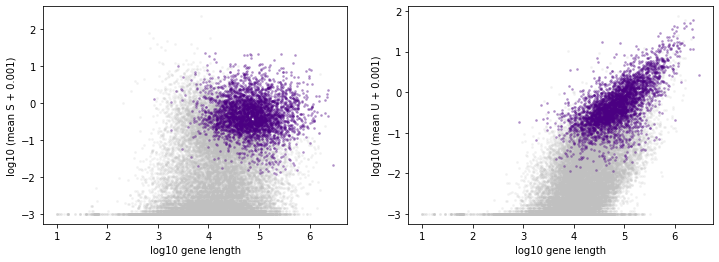

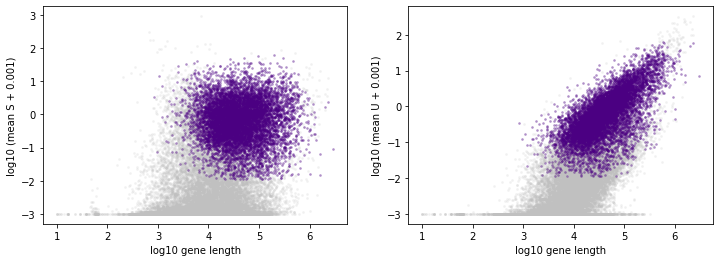

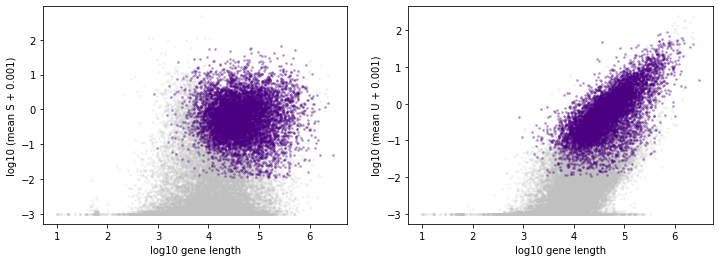

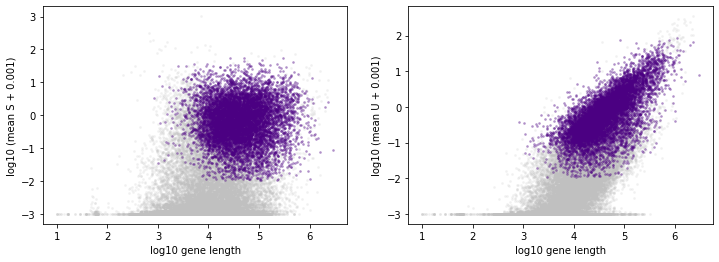

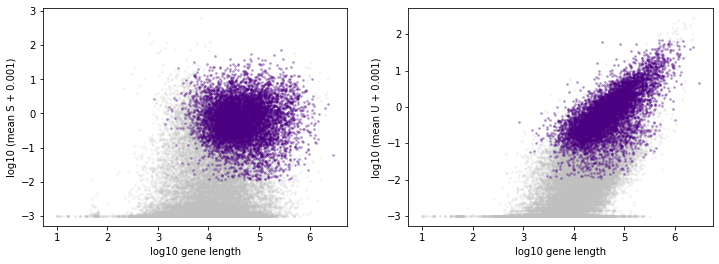

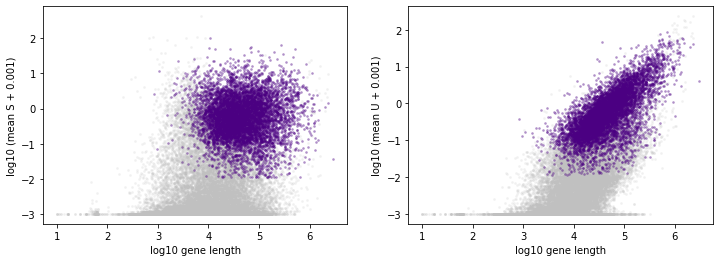

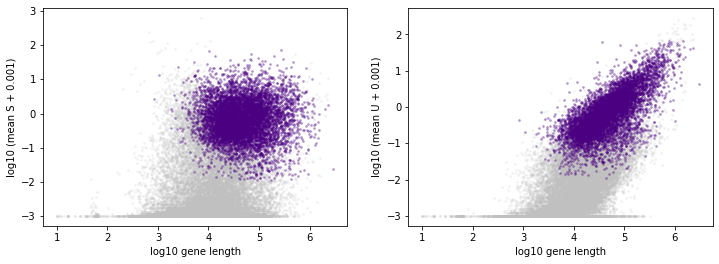

In [10]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='allen_noisefree',batch_id=1,\
                                             n_genes=2500,exp_filter_threshold=None,cf=cf)

## Inference

Fit the model.


In [11]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 


INFO:root:Sequencing model set to None. All sampling parameters set to null.
INFO:root:Directory ./fits/gg_221119_025_allen_noisefree_1/allen_B05/Bursty_None_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_221119_025_allen_noisefree_1/allen_B05/Bursty_None_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_B05
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_221119_025_allen_noisefree_1/genes.csv.
INFO:root:Directory ./fits/gg_221119_025_allen_noisefree_1/allen_B05/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_221119_025_allen_noisefree_1/allen_B05/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:Non-parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_221119_025_allen_noisefree_1/allen_B05/Bursty_None_1x1/analysis_figures created.
INFO:root:Runtime: 75.2 

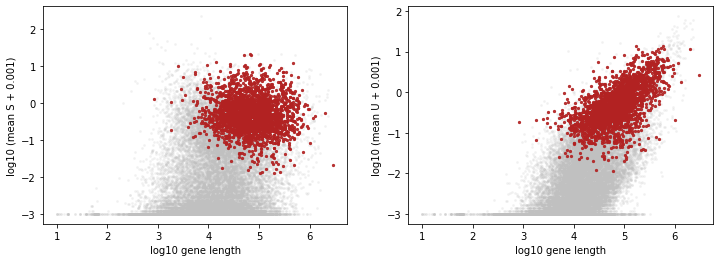

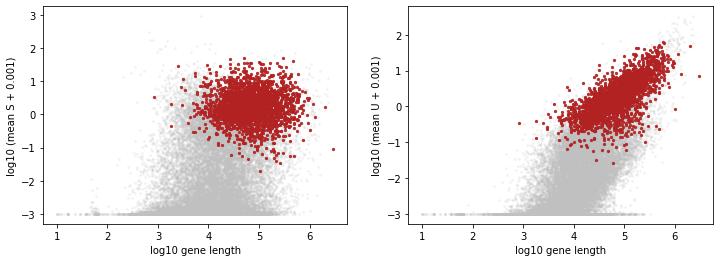

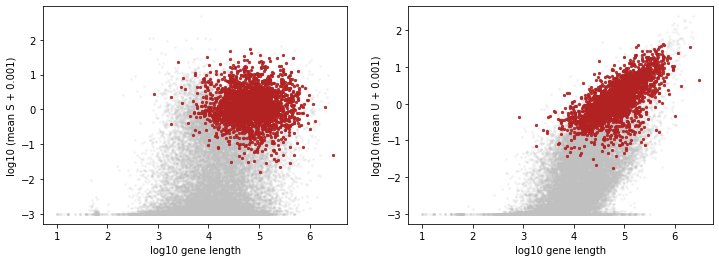

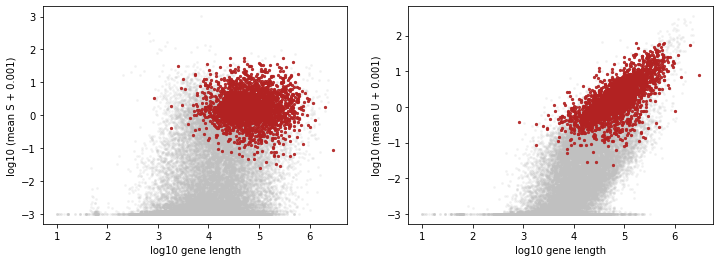

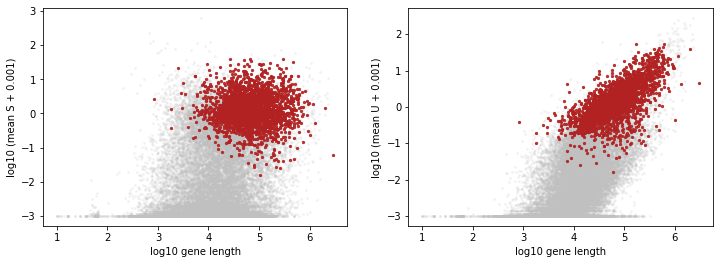

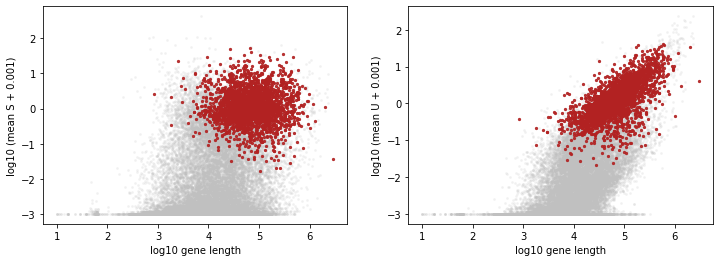

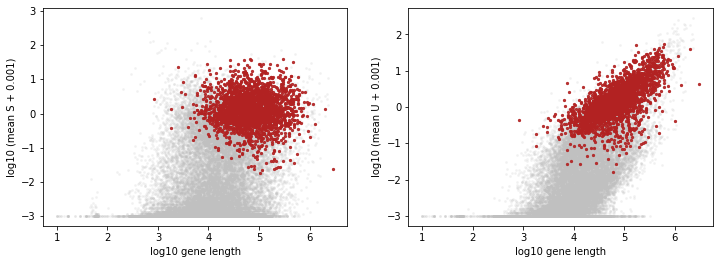

In [12]:
phys_lb = [-1.0, -1.8, -1.8 ]
phys_ub = [4.2, 2.5, 3.5]
samp_lb = [1,1]
samp_ub = [1,1]
gridsize = [1,1]



result_strings = []
for i in range(n_datasets):
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','None')
    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = False,
                gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':1})
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])
    full_result_string = inference_parameters.fit_all_grid_points(1,search_data)
    result_strings.append(full_result_string)

## Post-processing

Load in data and do basic QC: test parameter trends and goodness-of-fit.


In [13]:
dataset_names

['allen_B05',
 'allen_B08',
 'allen_C01',
 'allen_F08',
 'allen_H12',
 'allen_B01',
 'allen_A01']

In [14]:
dir_string

'./fits/gg_221119_025_allen_noisefree_1'

In [15]:
result_strings

['./fits/gg_221119_025_allen_noisefree_1/allen_B05/Bursty_None_1x1/grid_scan_results.res',
 './fits/gg_221119_025_allen_noisefree_1/allen_B08/Bursty_None_1x1/grid_scan_results.res',
 './fits/gg_221119_025_allen_noisefree_1/allen_C01/Bursty_None_1x1/grid_scan_results.res',
 './fits/gg_221119_025_allen_noisefree_1/allen_F08/Bursty_None_1x1/grid_scan_results.res',
 './fits/gg_221119_025_allen_noisefree_1/allen_H12/Bursty_None_1x1/grid_scan_results.res',
 './fits/gg_221119_025_allen_noisefree_1/allen_B01/Bursty_None_1x1/grid_scan_results.res',
 './fits/gg_221119_025_allen_noisefree_1/allen_A01/Bursty_None_1x1/grid_scan_results.res']

INFO:root:Grid scan results loaded from ./fits/gg_221119_025_allen_noisefree_1/allen_B05/Bursty_None_1x1/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_221119_025_allen_noisefree_1/allen_B05/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_221119_025_allen_noisefree_1/allen_B05/Bursty_None_1x1/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_221119_025_allen_noisefree_1/allen_B05/Bursty_None_1x1/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 314 genes out of 2500. Runtime: 6.0 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 29 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 499 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 589 gives negative s

/home/ggorin/projects/monod/src/monod/inference.py:1354: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_221119_025_allen_noisefree_1/allen_B05/Bursty_None_1x1/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_221119_025_allen_noisefree_1/allen_B05/Bursty_None_1x1/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_221119_025_allen_noisefree_1/analysis_figures created.
INFO:root:Grid scan results loaded from ./fits/gg_221119_025_allen_noisefree_1/allen_B08/Bursty_None_1x1/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_221119_025_allen_noisefree_1/allen_B08/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_221119_025_allen_noisefree_1/allen_B08/Bursty_None_1x1/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_221119_025_allen_noisefree_1/allen_B08/Bursty_None_1x1/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 488 genes out of 2500. Runtime: 27.3 seconds.
INFO:root:Computing

/home/ggorin/projects/monod/src/monod/inference.py:1354: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_221119_025_allen_noisefree_1/allen_B08/Bursty_None_1x1/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_221119_025_allen_noisefree_1/allen_B08/Bursty_None_1x1/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_221119_025_allen_noisefree_1/analysis_figures already exists.
INFO:root:Grid scan results loaded from ./fits/gg_221119_025_allen_noisefree_1/allen_C01/Bursty_None_1x1/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_221119_025_allen_noisefree_1/allen_C01/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_221119_025_allen_noisefree_1/allen_C01/Bursty_None_1x1/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_221119_025_allen_noisefree_1/allen_C01/Bursty_None_1x1/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 211 genes out of 2500. Runtime: 16.9 seconds.
INFO:root:Co

/home/ggorin/projects/monod/src/monod/inference.py:1354: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_221119_025_allen_noisefree_1/allen_C01/Bursty_None_1x1/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_221119_025_allen_noisefree_1/allen_C01/Bursty_None_1x1/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_221119_025_allen_noisefree_1/analysis_figures already exists.
INFO:root:Grid scan results loaded from ./fits/gg_221119_025_allen_noisefree_1/allen_F08/Bursty_None_1x1/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_221119_025_allen_noisefree_1/allen_F08/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_221119_025_allen_noisefree_1/allen_F08/Bursty_None_1x1/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_221119_025_allen_noisefree_1/allen_F08/Bursty_None_1x1/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 504 genes out of 2500. Runtime: 23.2 seconds.
INFO:root:Co

/home/ggorin/projects/monod/src/monod/inference.py:1354: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_221119_025_allen_noisefree_1/allen_F08/Bursty_None_1x1/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_221119_025_allen_noisefree_1/allen_F08/Bursty_None_1x1/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_221119_025_allen_noisefree_1/analysis_figures already exists.
INFO:root:Grid scan results loaded from ./fits/gg_221119_025_allen_noisefree_1/allen_H12/Bursty_None_1x1/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_221119_025_allen_noisefree_1/allen_H12/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_221119_025_allen_noisefree_1/allen_H12/Bursty_None_1x1/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_221119_025_allen_noisefree_1/allen_H12/Bursty_None_1x1/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 316 genes out of 2500. Runtime: 15.7 seconds.
INFO:root:Co

/home/ggorin/projects/monod/src/monod/inference.py:1354: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_221119_025_allen_noisefree_1/allen_H12/Bursty_None_1x1/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_221119_025_allen_noisefree_1/allen_H12/Bursty_None_1x1/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_221119_025_allen_noisefree_1/analysis_figures already exists.
INFO:root:Grid scan results loaded from ./fits/gg_221119_025_allen_noisefree_1/allen_B01/Bursty_None_1x1/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_221119_025_allen_noisefree_1/allen_B01/raw.sd.
INFO:root:No rejection statistics have been computed.


/tmp/ipykernel_3754904/3089140836.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig1,ax1 = plt.subplots(1,1)


INFO:root:Figure stored to ./fits/gg_221119_025_allen_noisefree_1/allen_B01/Bursty_None_1x1/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_221119_025_allen_noisefree_1/allen_B01/Bursty_None_1x1/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 216 genes out of 2500. Runtime: 15.8 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 6 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 64 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 453 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 475 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 478 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 

/home/ggorin/projects/monod/src/monod/inference.py:1354: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_221119_025_allen_noisefree_1/allen_B01/Bursty_None_1x1/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_221119_025_allen_noisefree_1/allen_B01/Bursty_None_1x1/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_221119_025_allen_noisefree_1/analysis_figures already exists.
INFO:root:Grid scan results loaded from ./fits/gg_221119_025_allen_noisefree_1/allen_A01/Bursty_None_1x1/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_221119_025_allen_noisefree_1/allen_A01/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_221119_025_allen_noisefree_1/allen_A01/Bursty_None_1x1/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_221119_025_allen_noisefree_1/allen_A01/Bursty_None_1x1/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 378 genes out of 2500. Runtime: 16.7 seconds.
INFO:root:Co

/home/ggorin/projects/monod/src/monod/inference.py:1354: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_221119_025_allen_noisefree_1/allen_A01/Bursty_None_1x1/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_221119_025_allen_noisefree_1/allen_A01/Bursty_None_1x1/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_221119_025_allen_noisefree_1/analysis_figures already exists.


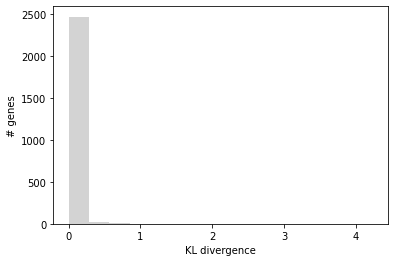

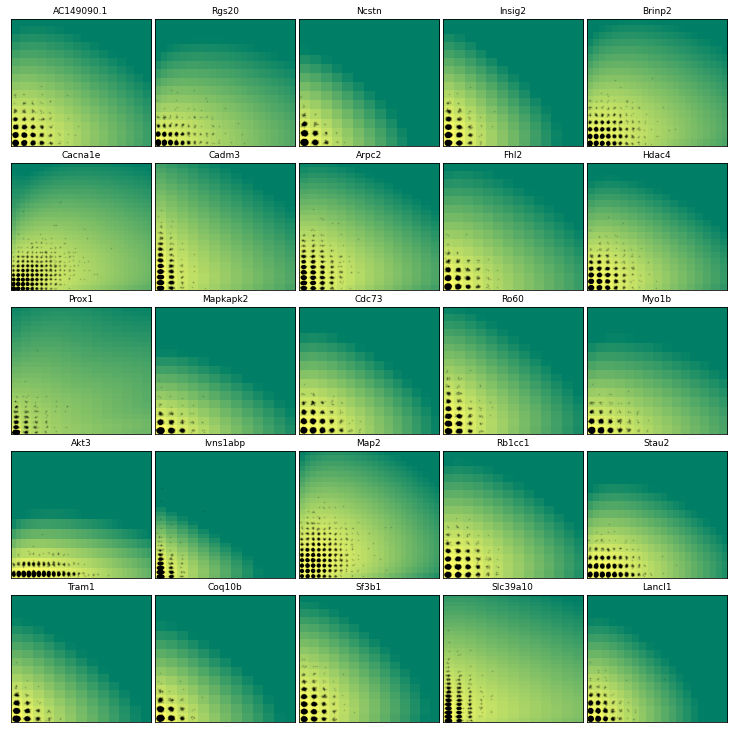

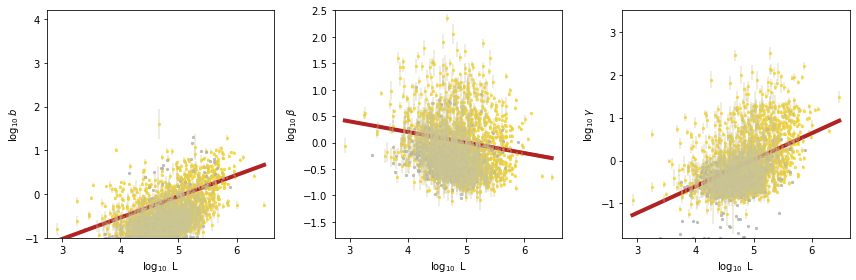

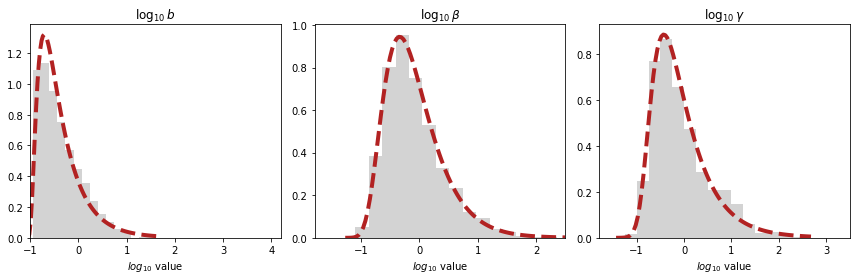

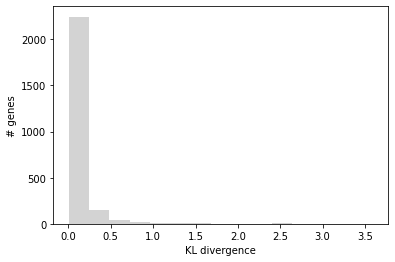

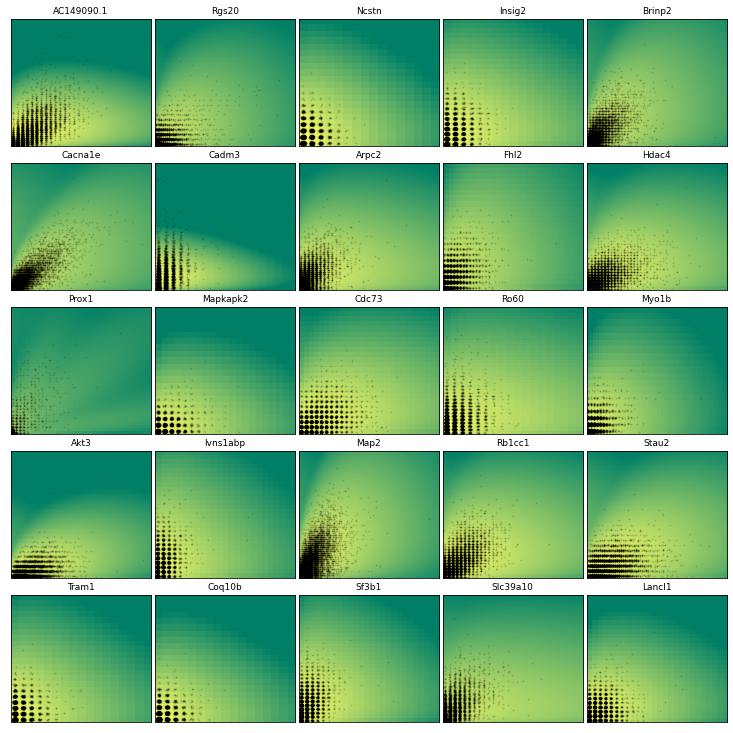

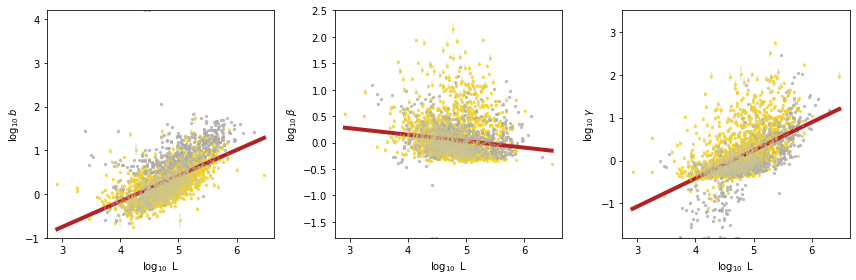

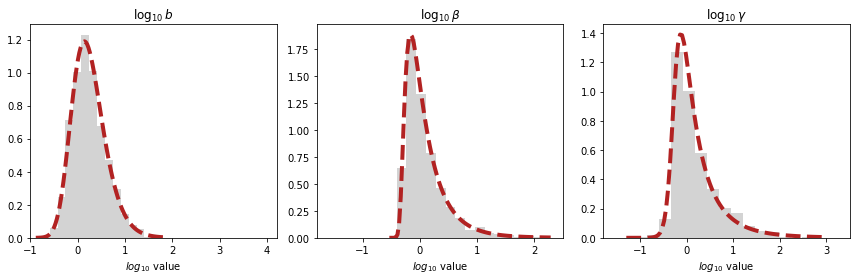

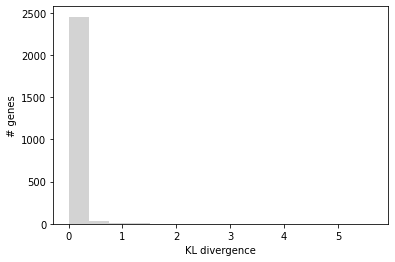

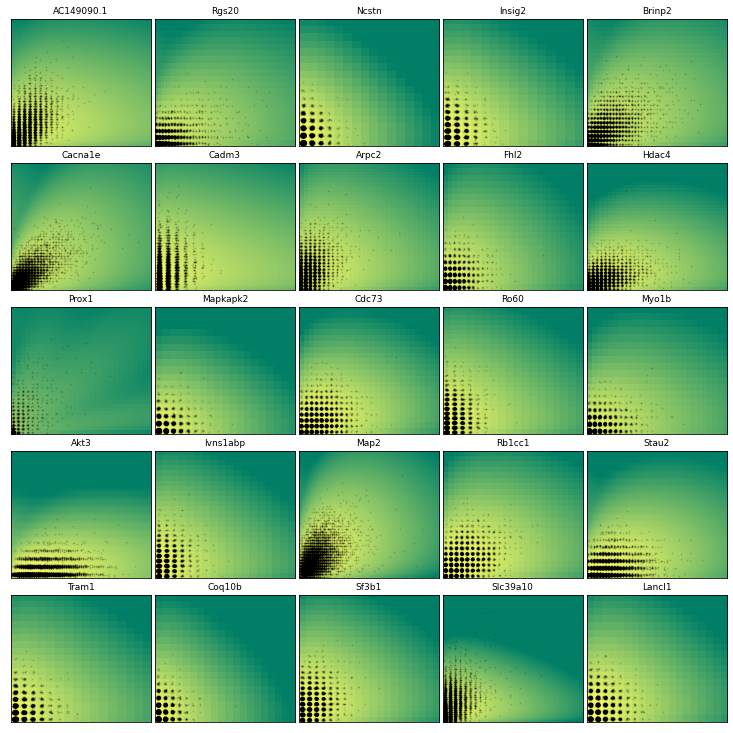

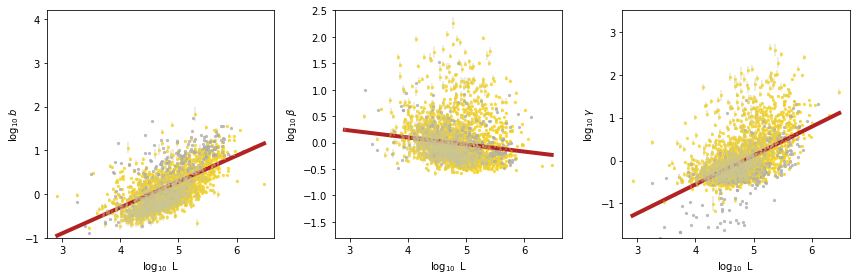

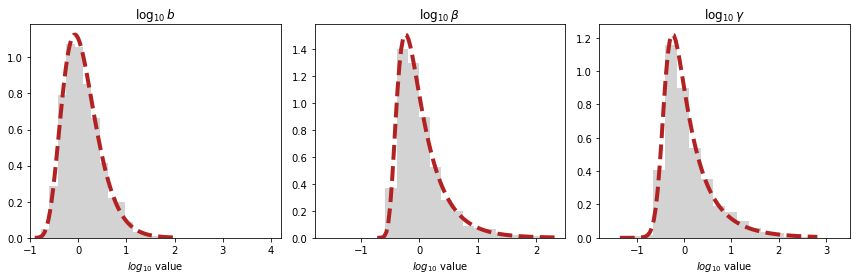

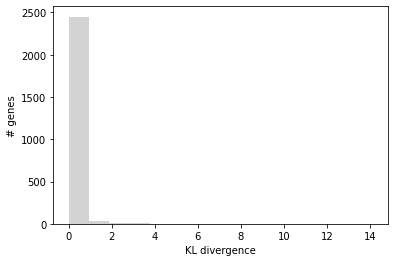

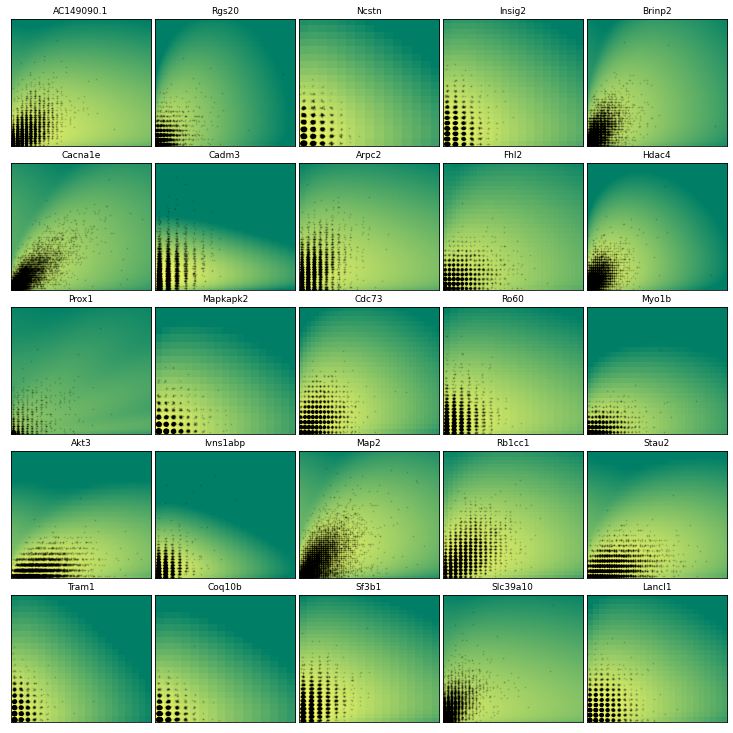

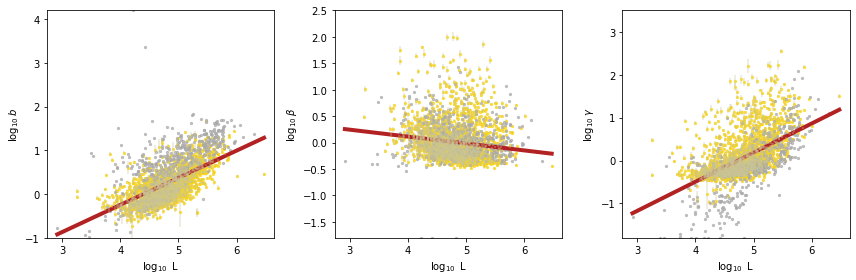

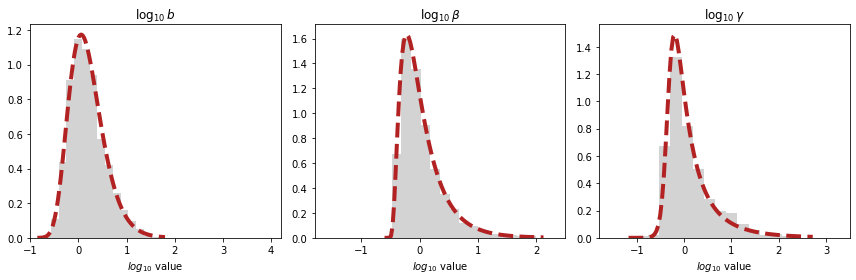

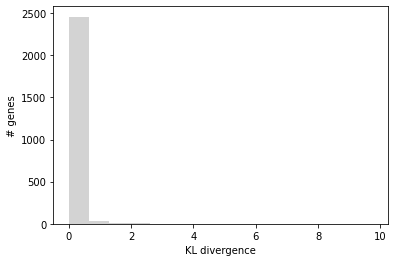

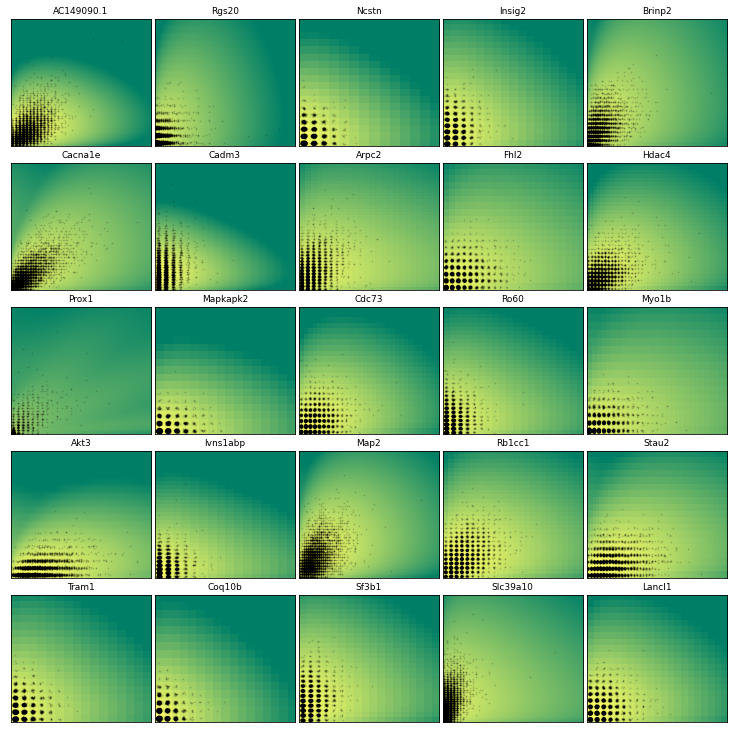

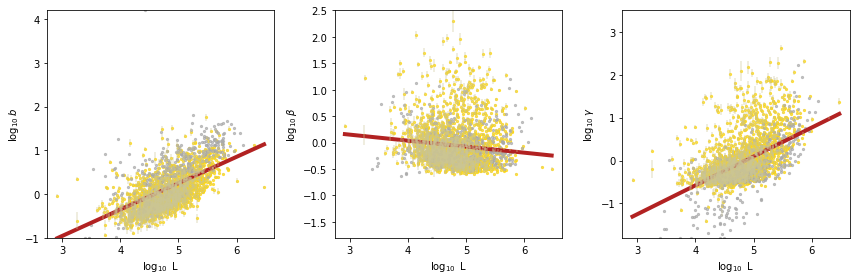

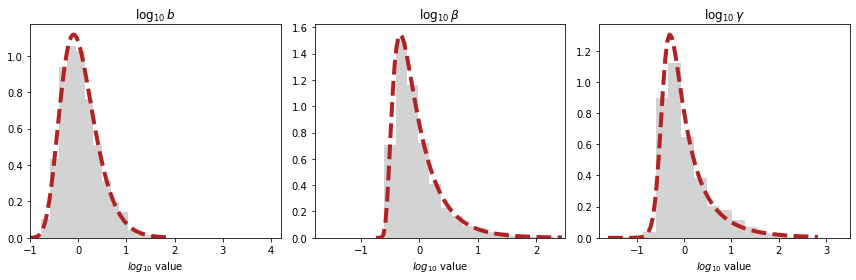

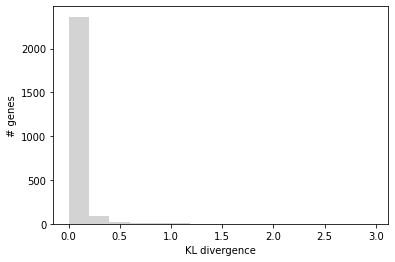

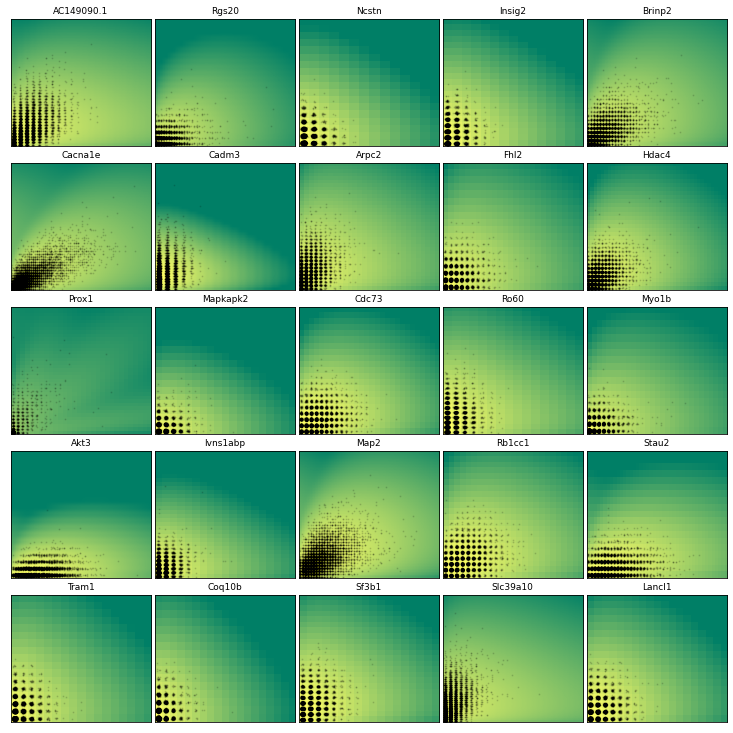

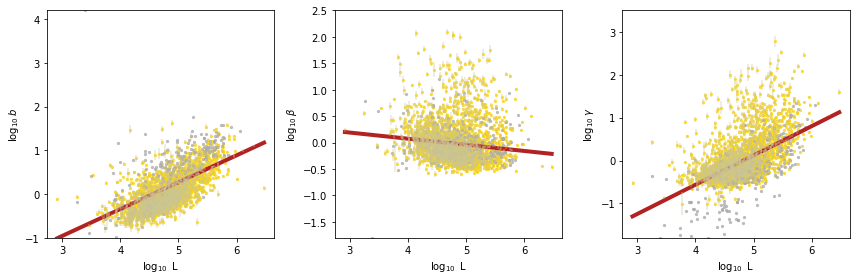

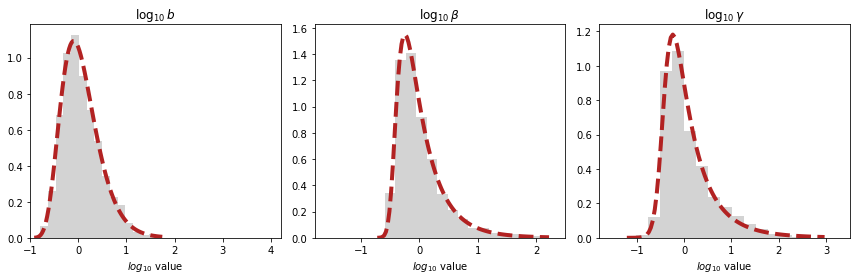

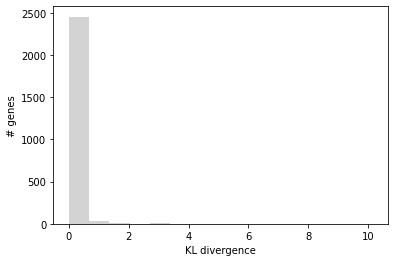

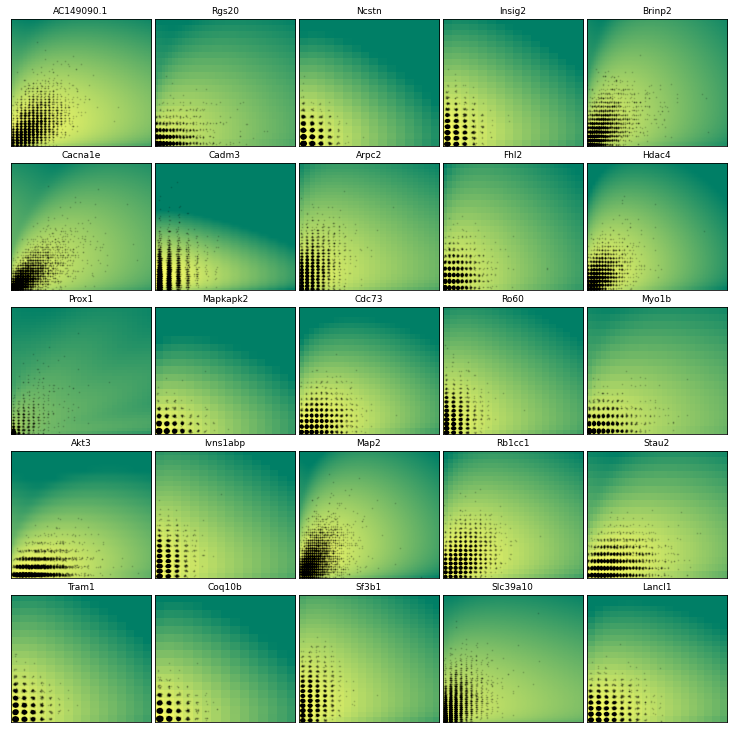

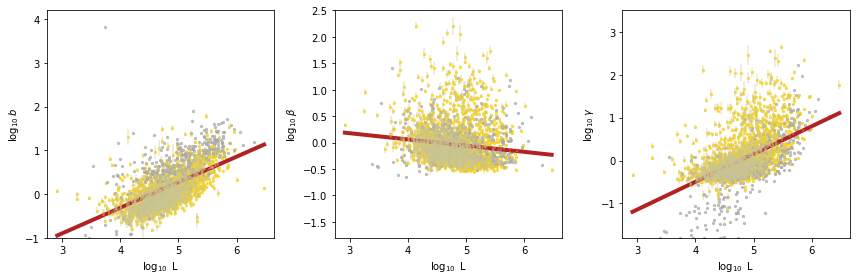

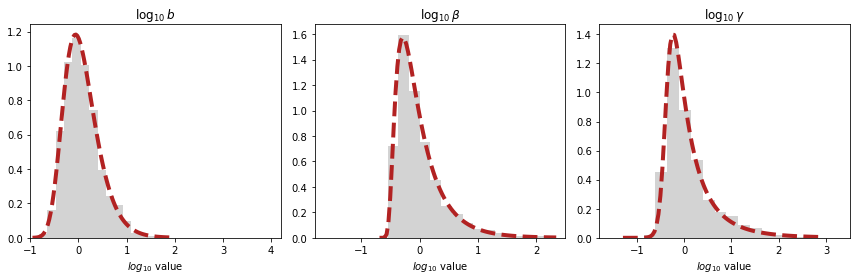

In [16]:
sr_arr = []
sd_arr = []
for i in range(n_datasets):
    sr = monod.analysis.load_search_results(result_strings[i])
    sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[i]+'/raw.sd')
    sr.find_sampling_optimum()

    fig1,ax1 = plt.subplots(1,1)
    sr.plot_KL(ax1)

    sr.plot_gene_distributions(sd,marg='joint')

    _=sr.chisquare_testing(sd,threshold=0.01)

    sr.compute_sigma(sd,num_cores=60)
    sr.plot_param_L_dep(plot_errorbars=True,plot_fit=True)
    sr.plot_param_marg()
    
    monod.analysis.make_batch_analysis_dir([sr],dir_string)
    sr.update_on_disk()
    
    sr_arr.append(sr)
    sd_arr.append(sd)
